<a href="https://colab.research.google.com/github/vasilijeIT23/PPPO_Age_Gender_Emotion_Detection/blob/main/pppo_age_first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import zipfile
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from PIL import Image
import math
import shutil
import random
import csv

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
def count_files_per_folder(root_folder):
    folder_file_count = []

    for foldername, subfolders, filenames in os.walk(root_folder):
        # Exclude the root folder itself
        if foldername != "dont_include":
            file_count = len(filenames)
            folder_file_count.append((foldername, file_count))

    return folder_file_count

def unzip_file(zip_file_path, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to the destination folder
        zip_ref.extractall(destination_folder)

def convert_images_to_grayscale(input_root_folder, output_root_folder):
    for foldername, _, filenames in os.walk(input_root_folder):
        # Create a corresponding subfolder structure within the output folder
        output_subfolder = foldername.replace(input_root_folder, output_root_folder)

        for filename in filenames:
            file_path = os.path.join(foldername, filename)

            # Check if the file is an image (you can add more extensions if needed)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                # Open the image
                img = Image.open(file_path)

                # Convert to grayscale
                grayscale_img = img.convert('L')

                # Create the output folder if it doesn't exist
                os.makedirs(output_subfolder, exist_ok=True)

                # Specify the output path for the grayscale image
                output_path = os.path.join(output_subfolder, filename)

                # Save the grayscale image to the output folder
                grayscale_img.save(output_path)

def count_images_in_folder(folder):
    image_extensions = ['.png', '.jpg', '.jpeg', '.gif']
    image_count = sum(1 for file in os.listdir(folder) if file.lower().endswith(tuple(image_extensions)))
    return image_count

def tilt_image(image_path, degrees):
    img = Image.open(image_path)

    # Convert degrees to radians
    angle_radians = math.radians(degrees)

    # Tilt the image
    tilted_img = img.rotate(degrees)

    # Save the tilted image
    tilted_path = os.path.splitext(image_path)[0] + f'_tilted_{degrees}.jpg'
    tilted_img.save(tilted_path)

def mirror_and_tilt(image_path, degrees):
    img = Image.open(image_path)

    # Mirror the image (using transpose to achieve mirroring)
    mirrored_img = img.transpose(method=Image.FLIP_LEFT_RIGHT)

    # Tilt the mirrored image
    tilted_mirror_img = mirrored_img.rotate(degrees)

    # Save the mirrored and tilted image
    tilted_mirror_path = os.path.splitext(image_path)[0] + f'_tilted_mirror_{degrees}.jpg'
    tilted_mirror_img.save(tilted_mirror_path)

def augment_images(root_folder, tilt_threshold=200, mirror_tilt_threshold=75):
    for foldername, _, filenames in os.walk(root_folder):
        image_count = count_images_in_folder(foldername)

        # Exclude folders with more than tilt_threshold images from tilt augmentation
        if image_count > tilt_threshold:
            continue

        # For folders with less than mirror_tilt_threshold images, apply mirroring and additional tilting
        if image_count < mirror_tilt_threshold:
            for filename in filenames:
                file_path = os.path.join(foldername, filename)

                # Check if the file is an image
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    # Tilt the image 20 degrees to the left
                    tilt_image(file_path, -20)

                    # Tilt the original image by 20 degrees to the right
                    tilt_image(file_path, 20)

                    # Mirror the image and tilt the mirrored version
                    mirror_and_tilt(file_path, -20)
                    mirror_and_tilt(file_path, 20)
        else:
            # For folders with more than mirror_tilt_threshold images, apply only tilt augmentation
            for filename in filenames:
                file_path = os.path.join(foldername, filename)

                # Check if the file is an image
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                    # Tilt the image 20 degrees to the left
                    tilt_image(file_path, -20)

                    # Tilt the original image by 20 degrees to the right
                    tilt_image(file_path, 20)

def shuffle_and_copy_data(input_root_folder, output_train_folder, output_test_folder, split_ratio=0.7):
    # Iterate through each subfolder in the input root folder
    for foldername, _, filenames in os.walk(input_root_folder):
        # Skip the root folder itself
        if foldername == input_root_folder:
            continue

        # Shuffle the list of filenames
        random.shuffle(filenames)

        # Calculate the split index based on the split_ratio
        split_index = int(len(filenames) * split_ratio)

        # Create corresponding subfolders within the output folders
        output_train_subfolder = foldername.replace(input_root_folder, output_train_folder)
        output_test_subfolder = foldername.replace(input_root_folder, output_test_folder)

        # Create the output subfolders if they don't exist
        os.makedirs(output_train_subfolder, exist_ok=True)
        os.makedirs(output_test_subfolder, exist_ok=True)

        # Copy files to the train set
        for filename in filenames[:split_index]:
            source_path = os.path.join(foldername, filename)
            destination_path = os.path.join(output_train_subfolder, filename)
            shutil.copy2(source_path, destination_path)

        # Copy files to the test set
        for filename in filenames[split_index:]:
            source_path = os.path.join(foldername, filename)
            destination_path = os.path.join(output_test_subfolder, filename)
            shutil.copy2(source_path, destination_path)

def create_csv_from_folder(root_folder, input_folder, csv_file_path):
    with open(csv_file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        csv_writer.writerow(['image_name', 'age'])  # Header row

        for foldername, _, filenames in os.walk(input_folder):
            # Skip the root folder itself
            if foldername == input_folder:
                continue

            # Get the relative path to the root folder
            relative_path = os.path.join(foldername, root_folder)

            # Remove zeros at the beginning of the folder name
            age_label = os.path.basename(foldername)
            age_label = age_label.lstrip('0')

            for filename in filenames:
                file_relative_path = os.path.join(relative_path, filename)
                csv_writer.writerow([file_relative_path, age_label])

def move_files_to_parent_folder(root_folder):
    for foldername, _, filenames in os.walk(root_folder):
        # Skip the root folder itself
        if foldername == root_folder:
            continue

        for filename in filenames:
            source_path = os.path.join(foldername, filename)
            destination_path = os.path.join(root_folder, filename)

            # Move the file to the parent folder
            shutil.copy2(source_path, destination_path)

def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)
    return image_decoded, label

def class_labels_reassign(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 17:
        return 2
    elif 18 <= age <= 25:
        return 3
    elif 26 <= age <= 35:
        return 4
    elif 36 <= age <= 45:
        return 5
    elif 46 <= age <= 55:
        return 6
    elif 56 <= age <= 65:
        return 7
    elif 66 <= age <= 80:
        return 8
    else:
        return 9

def class_labels_reassign_new(age):
    if 1 <= age <= 8:
        return 0
    elif 9 <= age <= 19:
        return 1
    elif 20 <= age <= 31:
        return 2
    elif 32 <= age <= 60:
        return 3
    elif 60 <= age <= 110:
        return 4


In [ ]:
# Specify the path to the zip file and the destination folder
zip_file_path = '/content/drive/MyDrive/PPPO/face_age.zip'
destination_folder = '/content/drive/MyDrive/PPPO/initial_data'

# Call the function to unzip the file
unzip_file(zip_file_path, destination_folder)

print("Unzipping completed.")


In [8]:
# Specify the root folder you want to start counting from
root_folder = '/content/drive/MyDrive/PPPO/initial_data/face_age'

folder_file_count = count_files_per_folder(root_folder)

for folder, file_count in folder_file_count:
    print(f"Folder: {folder[len(folder)-3: len(folder)]}, Number of Files: {file_count}")

under_75 = []
under_150 = []
under_200 = []
under_300 = []

for folder, file_count in folder_file_count:
    if file_count <= 75:
        under_75.append((folder, file_count))
    if file_count <= 150:
        under_150.append((folder, file_count))
    if file_count <= 200:
        under_200.append((folder, file_count))
    if file_count <= 300:
        under_300.append((folder, file_count))


Folder: age, Number of Files: 0
Folder: 001, Number of Files: 1112
Folder: 002, Number of Files: 475
Folder: 003, Number of Files: 284
Folder: 004, Number of Files: 260
Folder: 005, Number of Files: 180
Folder: 006, Number of Files: 114
Folder: 007, Number of Files: 126
Folder: 008, Number of Files: 236
Folder: 009, Number of Files: 159
Folder: 010, Number of Files: 140
Folder: 011, Number of Files: 63
Folder: 012, Number of Files: 106
Folder: 013, Number of Files: 75
Folder: 014, Number of Files: 137
Folder: 015, Number of Files: 143
Folder: 016, Number of Files: 212
Folder: 017, Number of Files: 103
Folder: 018, Number of Files: 181
Folder: 019, Number of Files: 58
Folder: 020, Number of Files: 103
Folder: 021, Number of Files: 136
Folder: 022, Number of Files: 139
Folder: 023, Number of Files: 92
Folder: 024, Number of Files: 191
Folder: 025, Number of Files: 156
Folder: 026, Number of Files: 279
Folder: 027, Number of Files: 126
Folder: 028, Number of Files: 145
Folder: 029, Number

In [9]:
# Extract data for plotting
folders = [folder[len(folder)-3: len(folder)] for folder, _ in folder_file_count]
file_counts = [file_count for _, file_count in folder_file_count]

folders_75 = [folder[len(folder)-3: len(folder)] for folder, _ in under_75]
file_counts_75 = [file_count for _, file_count in under_75]

folders_150 = [folder[len(folder)-3: len(folder)] for folder, _ in under_150]
file_counts_150 = [file_count for _, file_count in under_150]

folders_200 = [folder[len(folder)-3: len(folder)] for folder, _ in under_200]
file_counts_200 = [file_count for _, file_count in under_200]

folders_300 = [folder[len(folder)-3: len(folder)] for folder, _ in under_300]
file_counts_300 = [file_count for _, file_count in under_300]

Num of folders under 75 is:  50


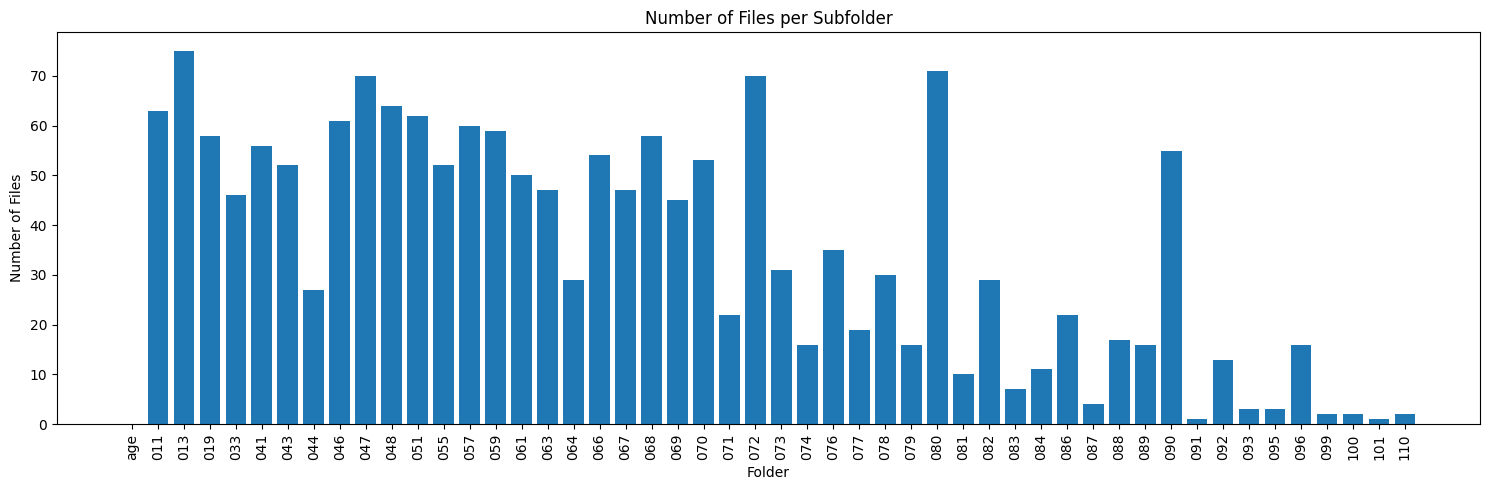

In [10]:
print("Num of folders under 75 is: ", len(under_75))

# Plotting
plt.figure(figsize=(15, 5))
plt.bar(folders_75, file_counts_75)
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files per Subfolder')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Num of folders under 150 is:  88


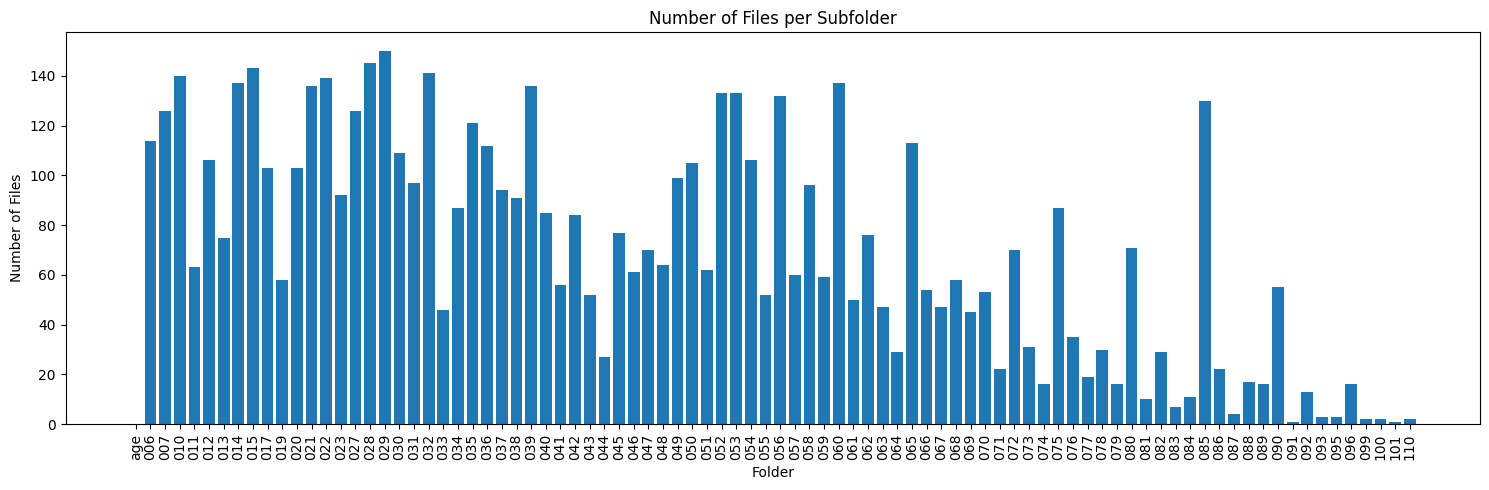

In [11]:
print("Num of folders under 150 is: ", len(under_150))

# Plotting
plt.figure(figsize=(15, 5))
plt.bar(folders_150, file_counts_150)
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files per Subfolder')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Num of folders under 200 is:  93


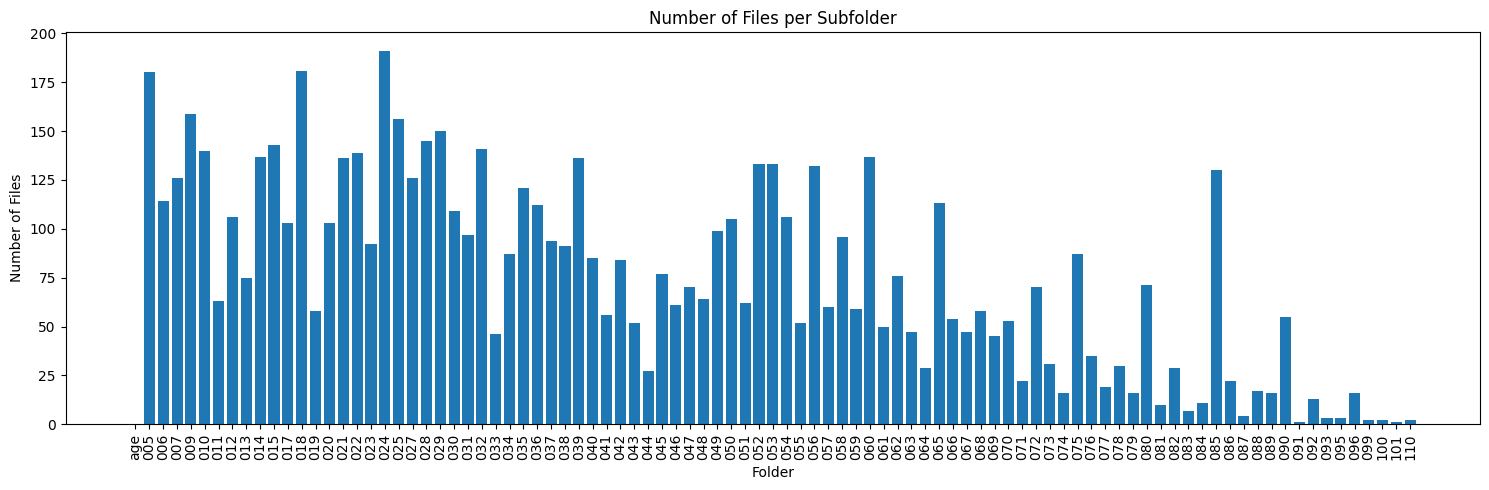

In [12]:
print("Num of folders under 200 is: ", len(under_200))

# Plotting
plt.figure(figsize=(15, 5))
plt.bar(folders_200, file_counts_200)
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files per Subfolder')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Num of folders under 300 is:  98


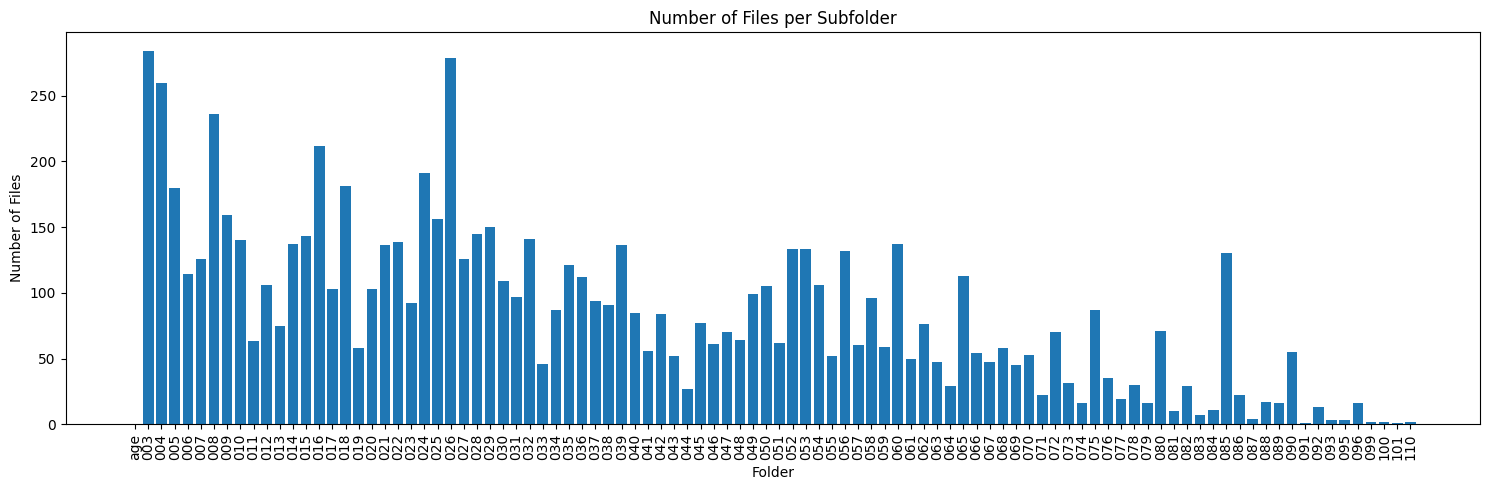

In [13]:
print("Num of folders under 300 is: ", len(under_300))

# Plotting
plt.figure(figsize=(15, 5))
plt.bar(folders_300, file_counts_300)
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files per Subfolder')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

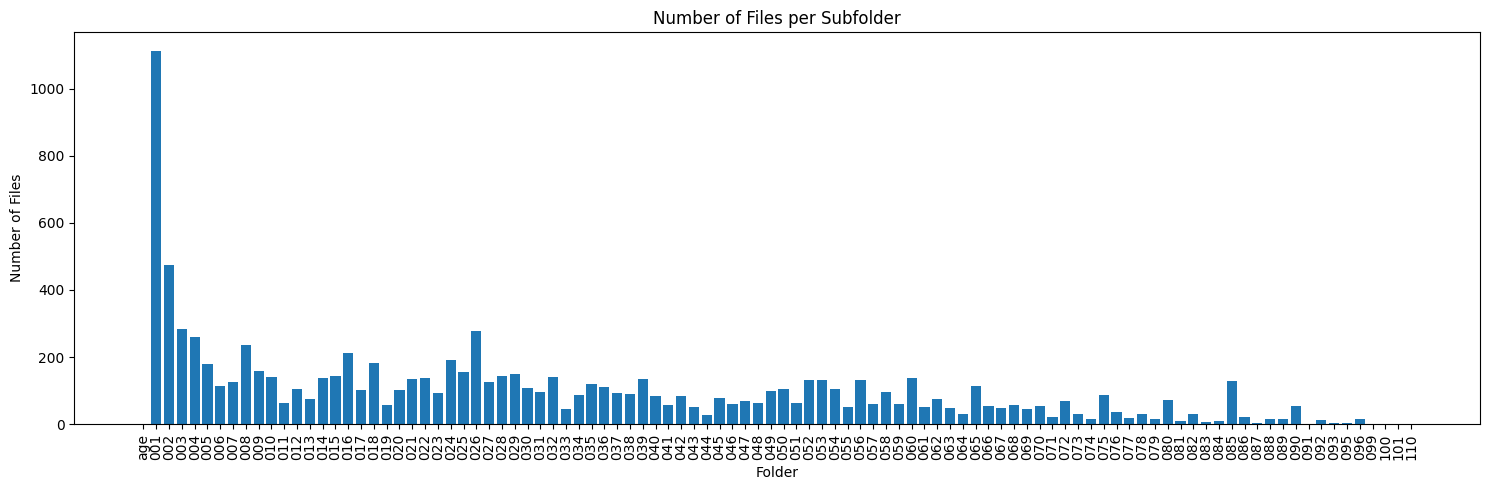

In [14]:
# Plotting
plt.figure(figsize=(15, 5))
plt.bar(folders, file_counts)
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files per Subfolder')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

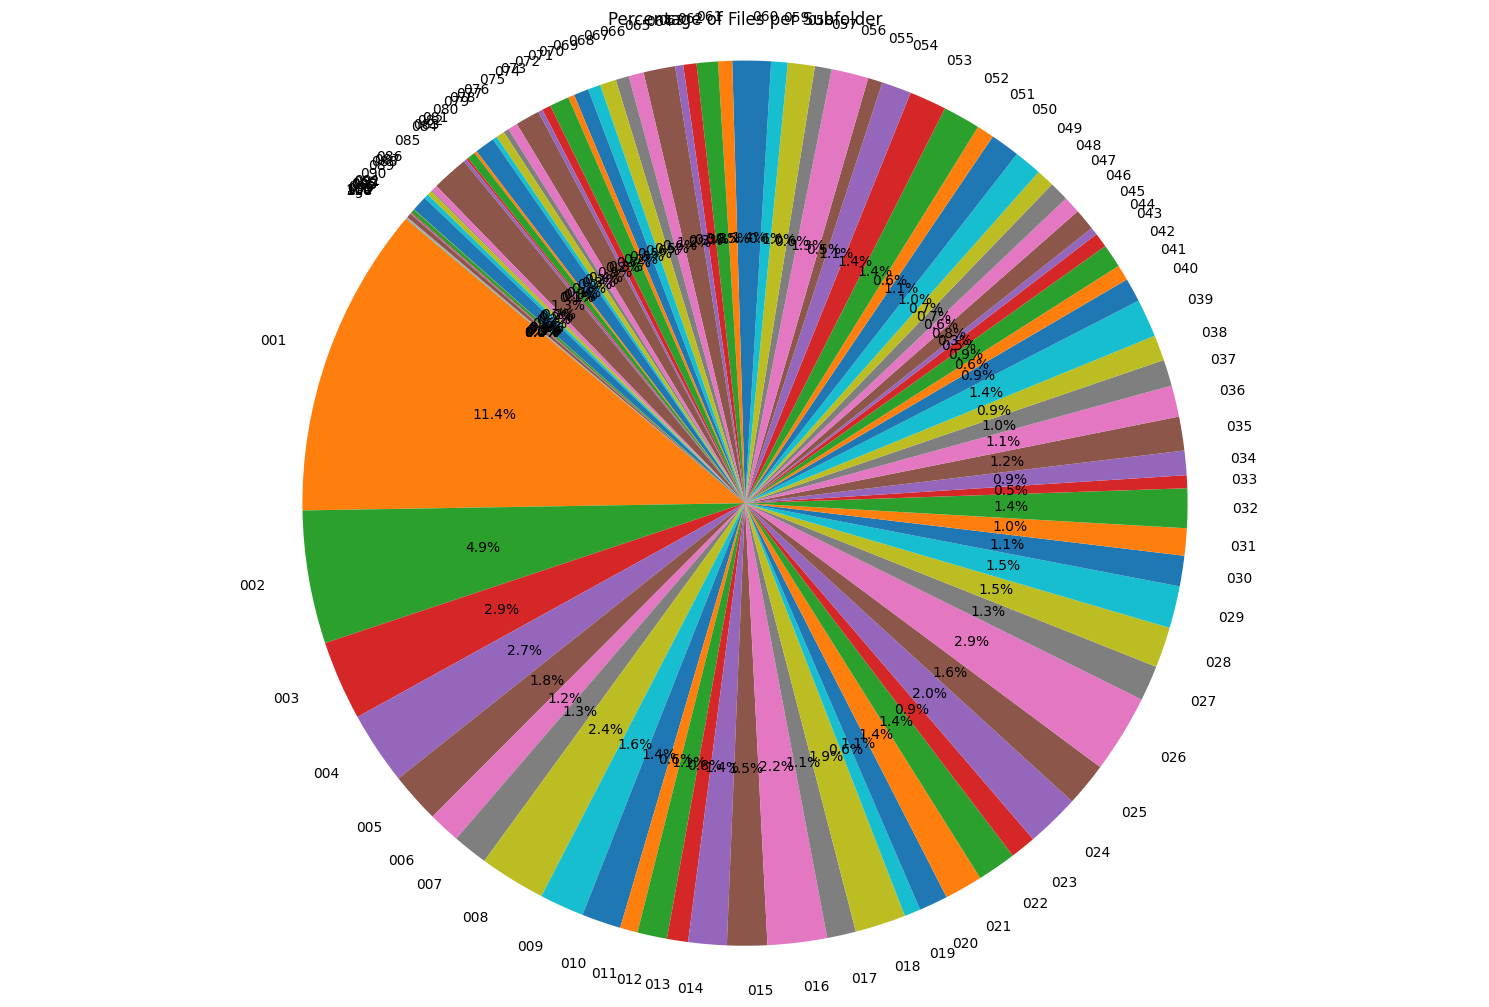

In [15]:
# Plotting Pie Chart
plt.figure(figsize=(15, 10))
plt.pie(file_counts, labels=folders, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Files per Subfolder')
plt.tight_layout()

plt.show()

In [ ]:
# Specify the input (original) root folder
input_root_folder = '/content/drive/MyDrive/PPPO/initial_data'
# Specify the output (converted) root folder
output_root_folder = '/content/drive/MyDrive/PPPO/augmented_data'

# Convert images to grayscale and save them in a different parent folder
convert_images_to_grayscale(input_root_folder, output_root_folder)

print("Conversion to grayscale completed.")

Conversion to grayscale completed.


In [ ]:
# Specify the root folder you want to start augmenting from
root_folder = '/content/drive/MyDrive/PPPO/augmented_data'

# Augment images by tilting and mirroring, adjusting based on image counts
augment_images(root_folder)

print("Image augmentation completed.")


Folder: age, Number of Files: 0
Folder: 001, Number of Files: 1112
Folder: 002, Number of Files: 475
Folder: 003, Number of Files: 284
Folder: 004, Number of Files: 260
Folder: 005, Number of Files: 540
Folder: 006, Number of Files: 342
Folder: 007, Number of Files: 378
Folder: 008, Number of Files: 236
Folder: 009, Number of Files: 477
Folder: 010, Number of Files: 420
Folder: 011, Number of Files: 315
Folder: 012, Number of Files: 318
Folder: 013, Number of Files: 225
Folder: 014, Number of Files: 411
Folder: 015, Number of Files: 429
Folder: 016, Number of Files: 212
Folder: 017, Number of Files: 309
Folder: 018, Number of Files: 543
Folder: 019, Number of Files: 290
Folder: 020, Number of Files: 309
Folder: 021, Number of Files: 408
Folder: 022, Number of Files: 417
Folder: 023, Number of Files: 276
Folder: 024, Number of Files: 573
Folder: 025, Number of Files: 468
Folder: 026, Number of Files: 279
Folder: 027, Number of Files: 378
Folder: 028, Number of Files: 435
Folder: 029, Nu

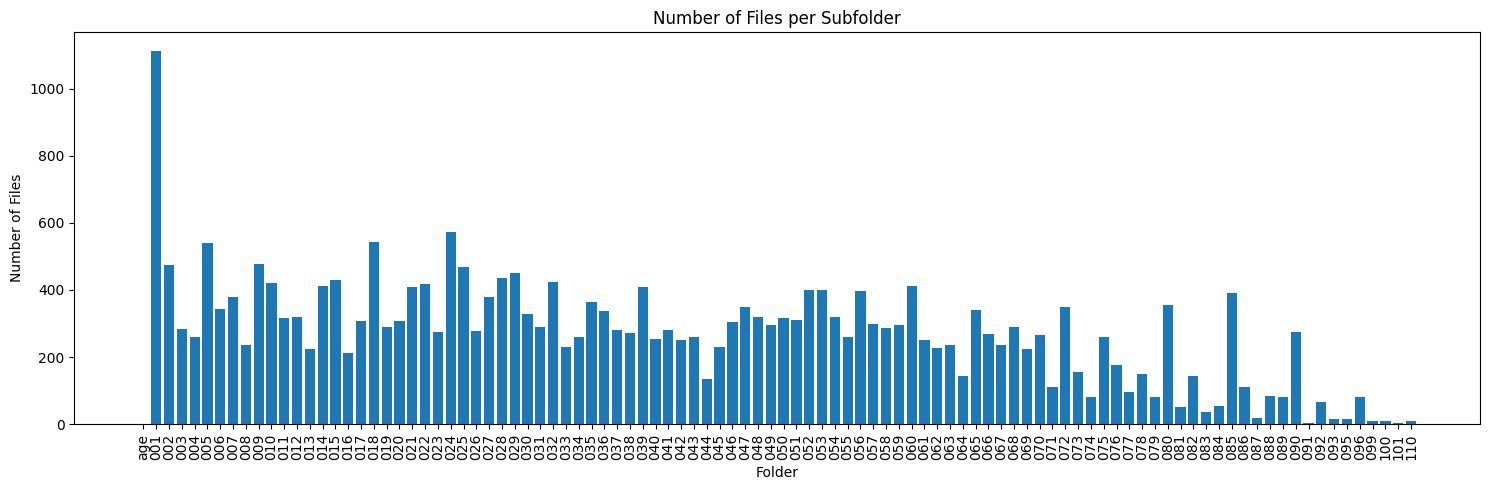

In [20]:
augmented_root_folder = '/content/drive/MyDrive/PPPO/augmented_data/face_age'

augmented_folder_file_count = count_files_per_folder(augmented_root_folder)

for folder, file_count in augmented_folder_file_count:
    print(f"Folder: {folder[len(folder)-3: len(folder)]}, Number of Files: {file_count}")


folders_augmented = [folder[len(folder)-3: len(folder)] for folder, _ in augmented_folder_file_count]
file_count_augmented = [file_count for _, file_count in augmented_folder_file_count]

print("Final amount of images: ", sum(file_count_augmented))

# Plotting
plt.figure(figsize=(15, 5))
plt.bar(folders_augmented, file_count_augmented)
plt.xlabel('Folder')
plt.ylabel('Number of Files')
plt.title('Number of Files per Subfolder')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

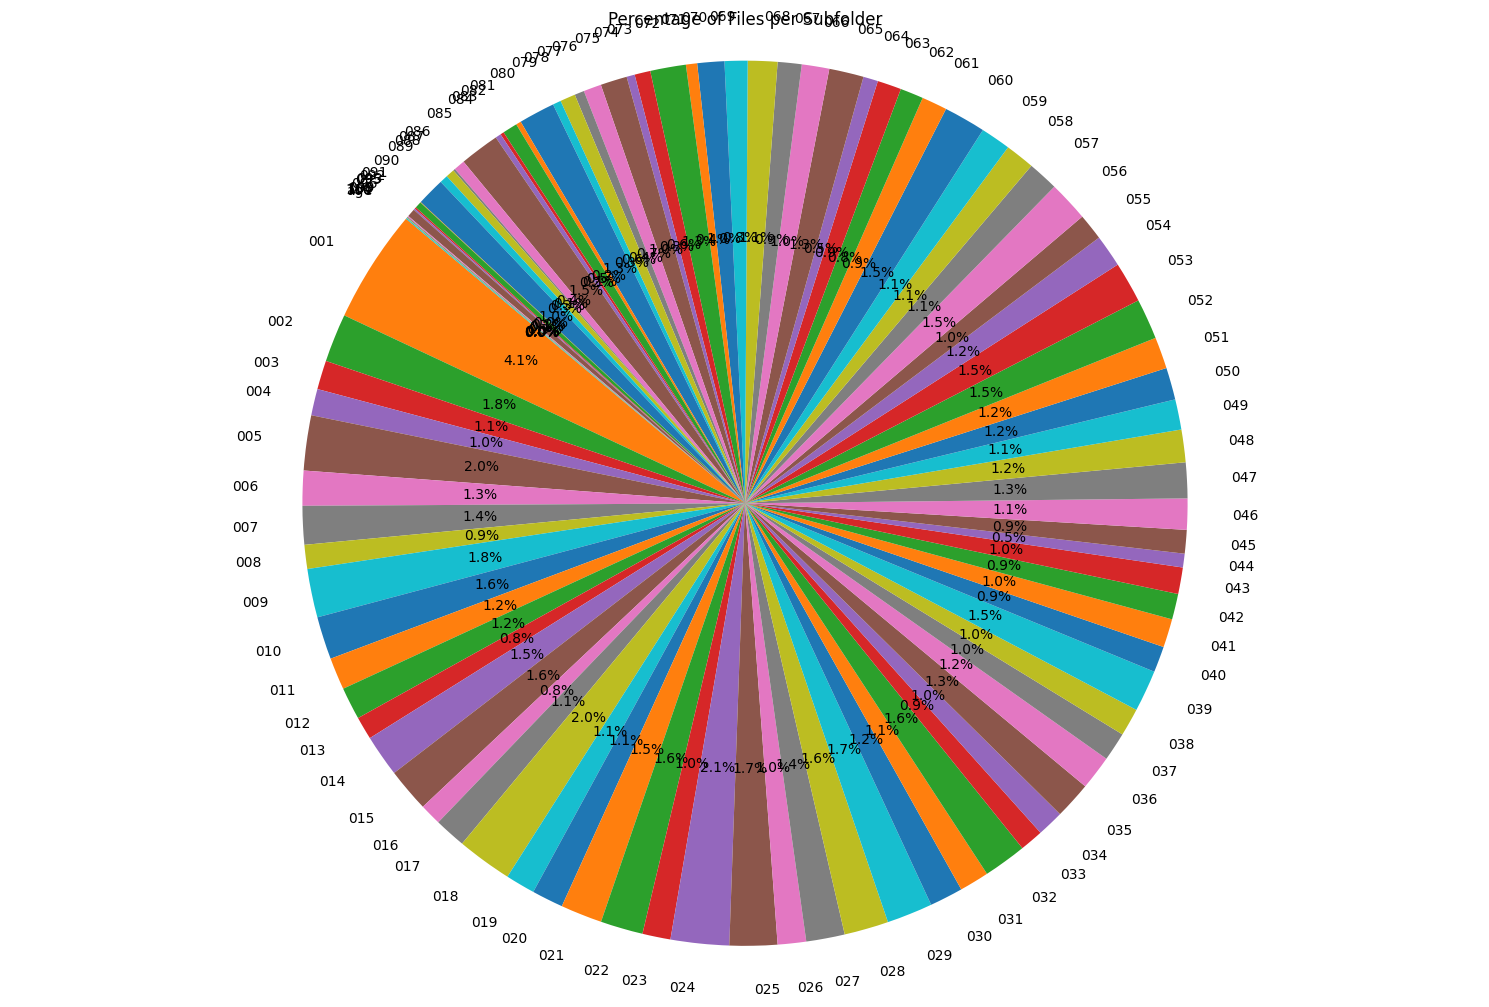

In [21]:
# Plotting Pie Chart
plt.figure(figsize=(15, 10))
plt.pie(file_count_augmented, labels=folders_augmented, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Files per Subfolder')
plt.tight_layout()

plt.show()

In [ ]:
# Specify the input (augmented) root folder
input_root_folder = '/content/drive/MyDrive/PPPO/augmented_data/face_age'
# Specify the output train and test folders
output_train_folder = '/content/drive/MyDrive/PPPO/augmented_data/train'
output_test_folder = '/content/drive/MyDrive/PPPO/augmented_data/test'

# Specify the split ratio (e.g., 0.7 for 70% train and 30% test)
split_ratio = 0.7

# Call the function to shuffle and copy data
shuffle_and_copy_data(input_root_folder, output_train_folder, output_test_folder, split_ratio)

print("Shuffling and copying completed.")


Shuffling and copying completed.


In [ ]:
train_root_folder = '/content/drive/MyDrive/PPPO/augmented_data/train'
test_root_folder = '/content/drive/MyDrive/PPPO/augmented_data/test'

train_folder_file_count = count_files_per_folder(train_root_folder)
test_folder_file_count = count_files_per_folder(test_root_folder)

file_count_train = [file_count for _, file_count in train_folder_file_count]
file_count_test = [file_count for _, file_count in test_folder_file_count]

print("Final amount of test images: ", sum(file_count_test))
print("Final amount of train images: ", sum(file_count_train))

Final amount of test images:  8103
Final amount of train images:  18789


In [ ]:
train_root_folder = '/content/drive/MyDrive/PPPO/augmented_data/train'
test_root_folder = '/content/drive/MyDrive/PPPO/augmented_data/test'

# Specify the paths for train and test sets
train_set_folder = '/content/drive/MyDrive/PPPO/augmented_data/train'
test_set_folder = '/content/drive/MyDrive/PPPO/augmented_data/test'

# Specify the paths for train and test CSV files
train_csv_path = '/content/drive/MyDrive/PPPO/augmented_data/train.csv'
test_csv_path = '/content/drive/MyDrive/PPPO/augmented_data/test.csv'

# Create CSV files for train and test sets
create_csv_from_folder(train_root_folder, train_set_folder, train_csv_path)
create_csv_from_folder(test_root_folder, test_set_folder, test_csv_path)

print("CSV files for train and test sets created.")


CSV files for train and test sets created.


In [ ]:
# Specify the root folder
train_root_folder = '/content/drive/MyDrive/PPPO/augmented_data/train'
test_root_folder = '/content/drive/MyDrive/PPPO/augmented_data/test'

# Call the function to move files to the parent folder
move_files_to_parent_folder(test_root_folder)
move_files_to_parent_folder(train_root_folder)

print("Files moved to the parent folder.")


Files moved to the parent folder.


In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/PPPO/augmented_data/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/PPPO/augmented_data/test.csv")

print(train_df)

                                              image_name  age
0      /content/drive/MyDrive/PPPO/augmented_data/tra...    1
1      /content/drive/MyDrive/PPPO/augmented_data/tra...    1
2      /content/drive/MyDrive/PPPO/augmented_data/tra...    1
3      /content/drive/MyDrive/PPPO/augmented_data/tra...    1
4      /content/drive/MyDrive/PPPO/augmented_data/tra...    1
...                                                  ...  ...
18784  /content/drive/MyDrive/PPPO/augmented_data/tra...  110
18785  /content/drive/MyDrive/PPPO/augmented_data/tra...  110
18786  /content/drive/MyDrive/PPPO/augmented_data/tra...  110
18787  /content/drive/MyDrive/PPPO/augmented_data/tra...  110
18788  /content/drive/MyDrive/PPPO/augmented_data/tra...  110

[18789 rows x 2 columns]


In [6]:
train_df['target'] = train_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [29]:
print(train_df)

                                              image_name  age  target
0      /content/drive/MyDrive/PPPO/augmented_data/tra...    1       0
1      /content/drive/MyDrive/PPPO/augmented_data/tra...    1       0
2      /content/drive/MyDrive/PPPO/augmented_data/tra...    1       0
3      /content/drive/MyDrive/PPPO/augmented_data/tra...    1       0
4      /content/drive/MyDrive/PPPO/augmented_data/tra...    1       0
...                                                  ...  ...     ...
18784  /content/drive/MyDrive/PPPO/augmented_data/tra...  110       9
18785  /content/drive/MyDrive/PPPO/augmented_data/tra...  110       9
18786  /content/drive/MyDrive/PPPO/augmented_data/tra...  110       9
18787  /content/drive/MyDrive/PPPO/augmented_data/tra...  110       9
18788  /content/drive/MyDrive/PPPO/augmented_data/tra...  110       9

[18789 rows x 3 columns]


In [7]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.
train_filenames_list = list(train_df['image_name'])
train_labels_list = list(train_df['target'])
test_filenames_list = list(test_df['image_name'])
test_labels_list = list(test_df['target'])

# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.
train_filenames_tensor = tf.constant(train_filenames_list)
train_labels_tensor = tf.constant(train_labels_list)
test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [31]:
print(train_filenames_tensor)
print(train_labels_list)

tf.Tensor(
[b'/content/drive/MyDrive/PPPO/augmented_data/train/7285.png'
 b'/content/drive/MyDrive/PPPO/augmented_data/train/8617.png'
 b'/content/drive/MyDrive/PPPO/augmented_data/train/8344.png' ...
 b'/content/drive/MyDrive/PPPO/augmented_data/train/3906_tilted_mirror_20.jpg'
 b'/content/drive/MyDrive/PPPO/augmented_data/train/9628.png'
 b'/content/drive/MyDrive/PPPO/augmented_data/train/9628_tilted_mirror_20.jpg'], shape=(18789,), dtype=string)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.
num_classes = 10

# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [ ]:
print(test_dataset)
print(train_dataset)

In [11]:
# Defining the architecture of the sequential neural network.
final_cnn = Sequential()
# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())
# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))
# Output layer with 10 nodes (equal to the no. of classes).
final_cnn.add(Dense(10, activation='softmax'))
final_cnn.summary()

# Compiling the above created CNN architecture.
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creating a TensorBoard callback object and saving it at the desired location.
tensorboard = TensorBoard(log_dir=f"/content/drive/MyDrive/output_logs/age_detection_model")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 16)      160       
                                                                 
 average_pooling2d_4 (Avera  (None, 99, 99, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 average_pooling2d_5 (Avera  (None, 48, 48, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 average_pooling2d_6 (Avera  (None, 23, 23, 64)       

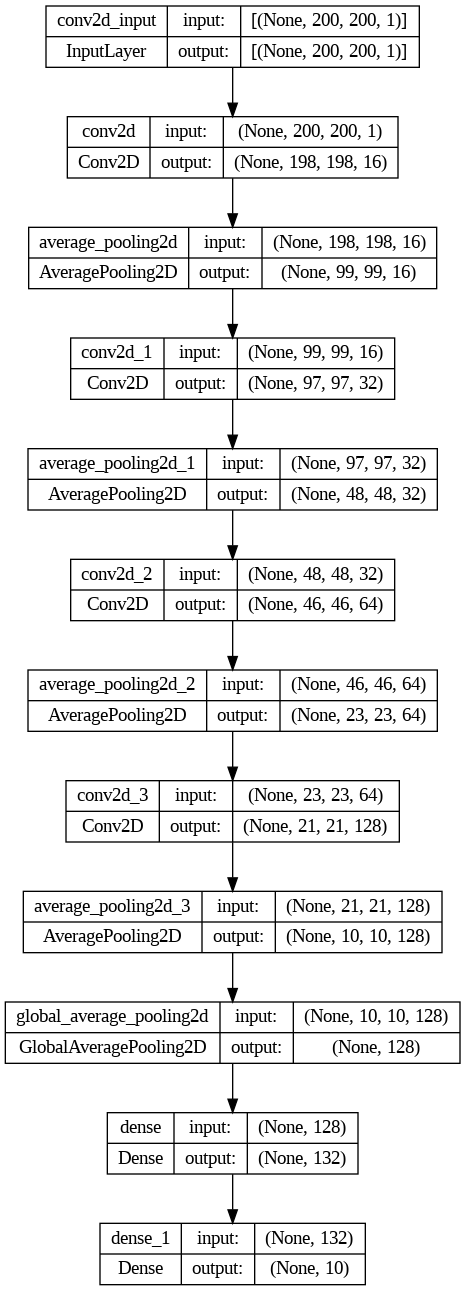

In [36]:
tf.keras.utils.plot_model(final_cnn,'model.png',show_shapes = True)

In [37]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/MyDrive/output_logs/age_detection_model/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )


In [41]:
os.path.exists('/content/drive/MyDrive/PPPO/augmented_data/test/4198_tilted_20.jpg')

True

In [ ]:
# Fitting the above created CNN model.
final_cnn_history = final_cnn.fit(train_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=10,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 2.3086 - accuracy: 0.1206 
Epoch 1: val_accuracy improved from -inf to 0.12156, saving model to /content/drive/MyDrive/output_logs/age_detection_model/age_model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 1539s 42s/step - loss: 2.3086 - accuracy: 0.1206 - val_loss: 2.2984 - val_accuracy: 0.1216
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 2.3045 - accuracy: 0.1214 
Epoch 2: val_accuracy improved from 0.12156 to 0.12193, saving model to /content/drive/MyDrive/output_logs/age_detection_model/age_model_checkpoint.h5
37/37 [==============================] - 855s 23s/step - loss: 2.3045 - accuracy: 0.1214 - val_loss: 2.2969 - val_accuracy: 0.1219
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 2.3028 - accuracy: 0.1216 
Epoch 3: val_accuracy did not improve from 0.12193
37/37 [==============================] - 867s 23s/step - loss: 2.3028 - accuracy: 0.1216 - val_loss: 2.2954 - val_accuracy: 0.1218
Epoch 4/10
37/37 [==============================] - ETA: 0s - loss: 2.3012 - accuracy: 0.1216 
Epoch 4: val_accuracy did not improve from 0.12193
37/37 [==============================] - 861s 23s/step - loss: 2.301

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/MyDrive/output_logs/age_detection_model/final_cnn_loss_accuracy.png', bbox_inches='tight');

NameError: ignored

In [12]:
# Evaluating the model on test dataset.
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)
# Printing the relevant score summary.
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

# Saving the model as a h5 file for possible use later.
final_cnn.save(f"/content/drive/MyDrive/output_logs/age_detection_model/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')


16/16 [==============================] - 1233s 76s/step - loss: 10.2933 - accuracy: 0.1008
CNN model loss 		= 10.293
CNN model accuracy 	= 0.101


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 104s 6s/step
Normalized confusion matrix


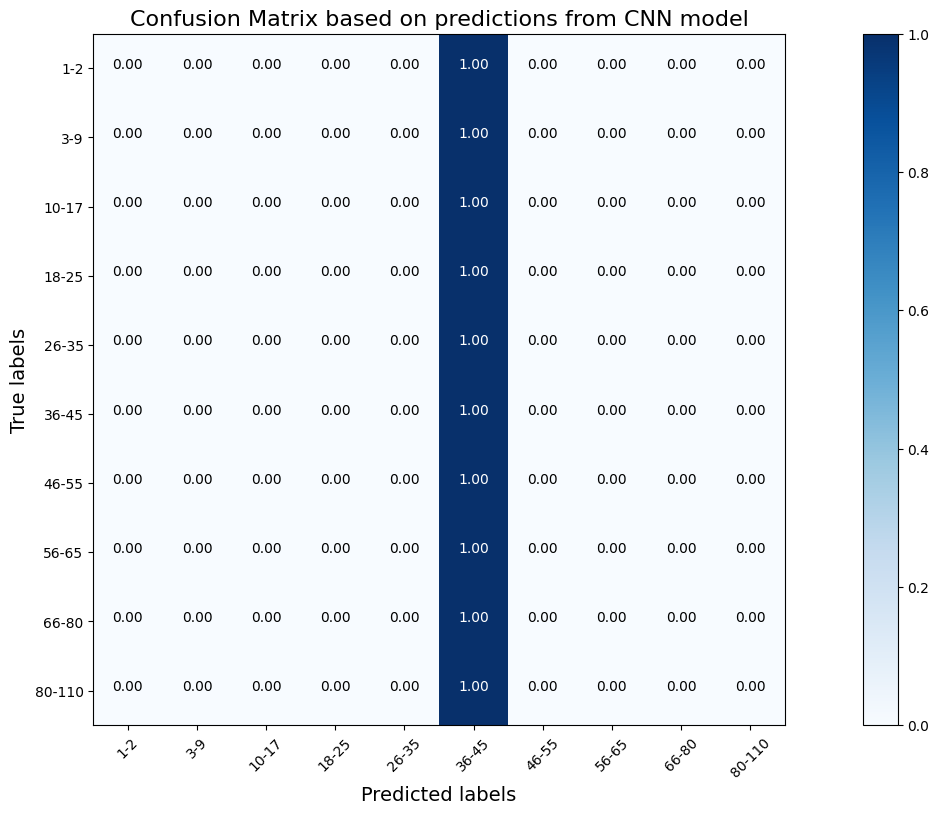

In [13]:
# Generating predictions from the model above.
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)
# Generating a confusion matrix based on above predictions.
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)

# Defining a function to plot the confusion matrix in a grid for easier visualization.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/MyDrive/output_logs/age_detection_model/{export_as}.png', bbox_inches='tight');

# Plotting the confusion matrix using the function defined above.
cm_plot_labels = ['1-2', '3-9', '10-17', '18-25', '26-35', '36-45', '46-55', '56-65', '66-80', '80-110']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()